In this document I will present my solutions, workings and thoughts on the DSL technical assessment. I've chosen to work in a Notebook in order to add thoughts and explanations where useful.   

The way to run this notebook is as follows:   
1. Optional: create and activate a venv  
2. Install the packages found in requirements.txt. I hope I haven't forgotten to add any imports.  
3. Set up the embeddings  
3a. Create a .env file and add your OpenAI API under the name openai_key  
3b. If you don't want this, I've pre-added the file reduced_embeddings so that no api call is needed. In that case, search for the variable 'env_and_api_added' and change it to False  
4. Add the assessment data as a .csv as 'listings_summary.csv' (I did not want to upload your assessment data to git)
5. Run the Notebook

---------------------------------------

## Assessment parameters
Name: DSL Assessment Data Scientist (GenAI specialisation)

Main objective: Predicting the price to rent an accomodation

Secondary objective(s): 
- Present technical know-how
- Show ability to think and present data as a consultant
- Seeing as I am applying to a GenAI-specific role, I will try to add a GenAI component where it adds value.

### Plan of action 
**1. Explore the dataset**  
I want to get a feel for what data we are working with, which dimensions we have to our disposal and how we can leverage the information to create an accurate, robust predictive model. Additionally, the data exploration could provide a first instinct as to how such a (algorithm-agnostic) predictive model could later on be put to production. For example, using unstructured text-data through embeddings would require a different processing pipeline than more orthodox numerical variables, which influences computional intensity, costs and scalability down the road.

**2. (Pre-)process the data**  
Once we know what the data looks like and roughly where we want to take our predictive model, we can start processing the data. Elements mentioned in the assessment are feature selection, pre-processing and creating a train/test-split. Let's drill down on that:
- Pre-processing: Possible steps are data cleaning, outlier detection & removal, data imputation, encoding categorical variables
- Feature selection: Many different methods from simple manual selection based on heuristics/domain knowledge to a more quantitative approach, such as training a simple Random Forest model and calculating feature importances
- Train/test split: Not strictly a part of data-processing, however I will discuss it here for convenience. The simplest method would be to choose some ratio between train and test data, such as 80/20. The higher the train-test ratio, the more data will be available in the training stage, however the more uncertainty there will be in the evaluation stage due to the smaller amount of test data. This is the main trade-off between different ratio's. Generally, I would choose some k-fold cross-validation approach here and calculate each KPI used for evaluation as a mean across runs. This also allows for systematic hyper-parameter tuning.

**3. Design, fit and evaluate the model**  
This stage is all about the choice of model, different choices' relative advantages and how to evaluate the performance of a trained model. The topics I could discuss are as follows:
- Model choice: Different models each have their own characteristics, applications and areas where they shine. The four dimensions I would like to consider in order to choose the right model for our application are the type of outcome variable, the underlying data-generating process, scalability and lastly explainability. Simply put, SVM's, for example, are generally not the right choice for predicting continuous variables whereas linear regression shines, however other models outperform linear regression if the underlying data-generating process is highly non-linear. Neural networks are generalists that can reach high performance in most any application given a sufficiently large amount of training data, but forego a lot of explainability. Random Forests, or boosted algorithms such as LightGBM or XGBoost, often find a nice balance between explainability, scalability and performance.
- Hyper-parameter tuning
- Evaluation: The choice of KPIs by which to score your model depends on the main objective of your project (see the classic cancer-detection vs. fraud-detection example). 

**4. Creating an E2E solution**  
Once we have a trained and evaluated POC model, we can start thinking about how it fits into an end-to-end solution design that drives the most value for the intended user. The goal here is to deliver a solution that fits into the user's way of working and delivers the exact insights the user requires without being simplistic or needlessly elaborate. Together these two elements of a good end-to-end solution will drive adoption and value. Topics to discuss could be: revised way-of-working, solution deployment, data refresh rate, user interface, data validation loop, collecting user feedback and more. 

**5. Practical topics**
- Scalability of the solution
- Data pipelines
- Monitoring model performance
- Ensuring solution up-time
- Automated testing
- CI/CD
- Dev and prod environments
- Infrastructure-as-code
- Hosting the solution

-------------------------------------

### 1. Exploring the dataset

In [77]:
# Imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data
df = pd.read_csv('listings_summary.csv')

# Columns
cols = df.columns
print(cols)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Immediately, it becomes clear the data contains a lot of columns. Many of these can be dropped immediately based on different heuristics.  
- **No predictive power:** id, listing_url, scrape_id, host_id, host_name, calendar_updated, calendar_last_scraped, other information on the host
- **Redundant information:** neighbourhood & neighbourhood_cleansed, latitude+longitude & zipcode, country & country code, all but one of the availability columns
- **(Overlap with) y-variable:** price, weekly_price, monthly_price, security_deposit, cleaning_fee

In [81]:
# Add these columns to the to-be-dropped list

# First identify columns with all None values, then drop them
columns_to_drop = ['name', 'id', 'listing_url', 'scrape_id', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'calendar_updated',            # No predictive power
                    'host_id', 'host_url', 'host_name','host_picture_url', 'host_thumbnail_url', 'last_scraped', 'calendar_last_scraped',                   # No predictive power
                    'host_since', 'host_location', 'host_about', 'host_response_rate', 'host_neighbourhood', 'host_verifications',                          # No predictive power
                    'first_review', 'last_review', 'host_response_time', 'host_has_profile_pic',  'extra_people',                                           # No predictive power
                    'neighbourhood', 'country', 'latitude', 'longitude','availability_30', 'availability_60', 'availability_90',                            # Redundant
                    'weekly_price', 'monthly_price', 'security_deposit','cleaning_fee',                                                                     # Related to y-variable 'price'
                ]


# From now on, 'price' will be regarded as our y-variable

There a few more columns that are questionable at best in terms of likely predictive power, such as 'requires_license', 'host_response_time' or 'require_guest_profile_picture', but these cannot be blindly dropped, so for the sake of completeness we will keep them for now.

In [82]:
# Now find all columns that are fully None/NaN
all_null_columns = df.columns[df.isnull().all()].tolist()
print(f"Columns with only None values: {all_null_columns}")

# Add these to the to-be-dropped list
columns_to_drop = columns_to_drop + all_null_columns

Columns with only None values: ['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 'jurisdiction_names']


After some more digging through the data (not everything shown), I can drop a few more columns for different reasons.
- host_listings_count & calculated_host_listings_count - identical to host_total_listings_count
- experiences_offered - empty row, but filled with string 'none', so not filtered by the step above
- is_business_travel_ready, country_code, has_availability, square_feet, license, requires_license, require_guest_profile_picture and require_guest_phone_verification, city, street and more - These columns contain the same value for more than 98% of rows, which does not provide information. Although it is theoretically possible they are predictive of price (expensive houses could have stricter guest policies for example), I am going to remove them.

In [83]:
dominant_value_columns = ['calculated_host_listings_count', 'host_listings_count', 'experiences_offered', 'license', 'requires_license', 'require_guest_profile_picture', 'require_guest_phone_verification',
                           'country_code', 'square_feet', 'has_availability', 'is_business_travel_ready', 'street', 'city', 'state', 'smart_location', 'market']

columns_to_drop = columns_to_drop + dominant_value_columns

# Drop all of these columns
df = df.drop(columns=columns_to_drop)

In [84]:
# Summary statistics can give us a quick indication of the data, which other columns might be useless or which columns contain outliers
df.describe().round(1)

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,22526.0,22552.0,22520.0,22534.0,22512.0,22552.0,22552.0,22552.0,22552.0,22552.0,18163.0,18138.0,18141.0,18120.0,18134.0,18121.0,18117.0,18638.0
mean,2.3,2.6,1.1,1.2,1.6,1.3,7.2,103050.5,79.9,17.8,94.4,9.7,9.3,9.7,9.7,9.5,9.4,1.1
std,19.9,1.5,0.3,0.6,1.2,0.8,40.7,9640519.3,119.4,36.8,7.6,0.7,1.0,0.7,0.7,0.8,0.8,1.5
min,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,20.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
25%,1.0,2.0,1.0,1.0,1.0,1.0,2.0,20.0,0.0,1.0,92.0,10.0,9.0,10.0,10.0,9.0,9.0,0.2
50%,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1124.0,4.0,5.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0.5
75%,2.0,3.0,1.0,1.0,2.0,1.0,4.0,1125.0,129.0,16.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1.5
max,1676.0,16.0,8.5,12.0,22.0,16.0,5000.0,999999999.0,365.0,498.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,36.7


In [85]:
# Final working dataset wdf
wdf = df

# Time for some exploration
# Let's convert our y-variable 'price' to an int - current format: $20.00
wdf['price'] = wdf['price'].str.replace('$', '').str.replace(',', '').astype(float).astype(int)

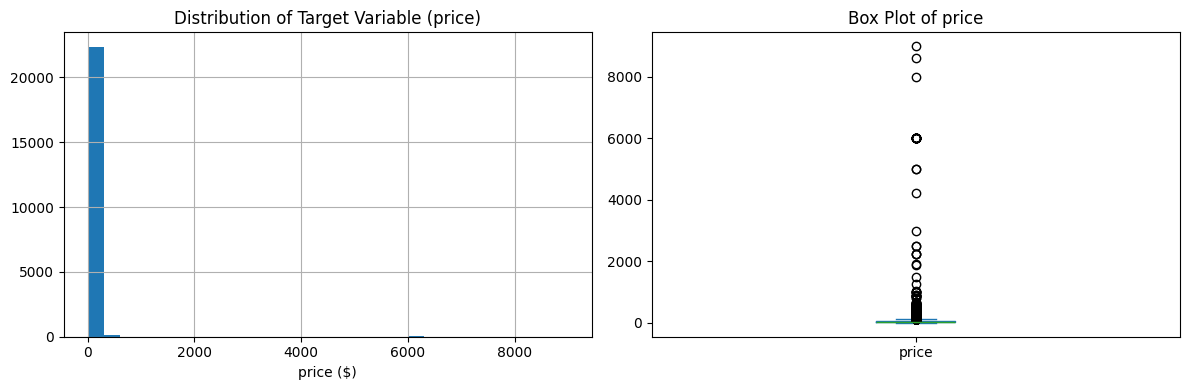

Target stats:
Mean: 67.14
Median: 45.00
Std: 220.27


In [86]:
# Analyze our target variable 'price'
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
wdf['price'].hist(bins=30)
plt.title('Distribution of Target Variable (price)')
plt.xlabel('price ($)')

plt.subplot(1, 2, 2)
wdf['price'].plot(kind='box')
plt.title('Box Plot of price')
plt.tight_layout()
plt.show()

print(f"Target stats:\nMean: {wdf['price'].mean():.2f}")
print(f"Median: {wdf['price'].median():.2f}")
print(f"Std: {wdf['price'].std():.2f}")

As 'price' represents price per night, it is quite surprising to me, although not strictly impossible, to see values in the thousands of dollars. A cursory glance at Google tells us that expensive hotel rooms in Berlin can go for approx. $200 a night (https://www.budgetyourtrip.com/hotels/germany/berlin-2950159#luxury-hotels). For this reason (and simplicity), I am dropping all rows with prices above $500, assuming they are outliers 

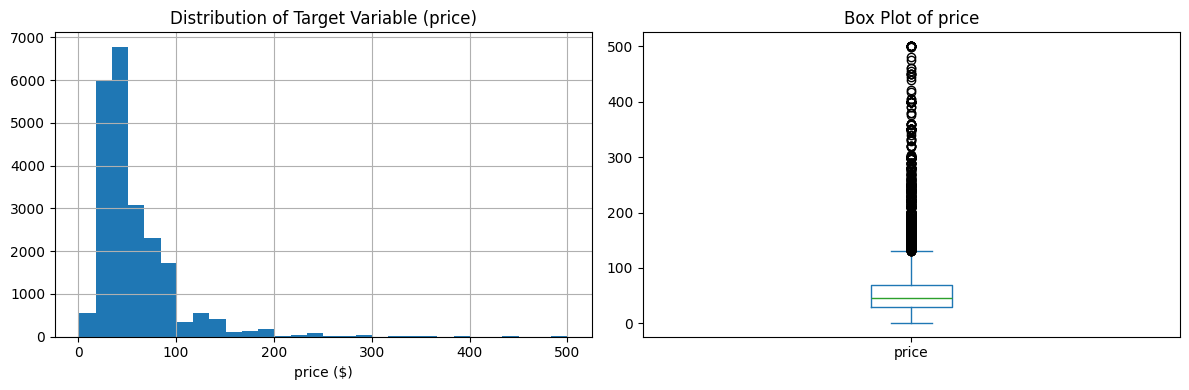

Target stats:
Mean: 58.12
Median: 45.00
Std: 44.69


In [87]:
# Analyze our target variable 'price' again, now filtered on outliers and 0 values

wdf = wdf[(wdf['price']>0) & (wdf['price']<=500)]

# Analyze our target variable 'price'
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
wdf['price'].hist(bins=30)
plt.title('Distribution of Target Variable (price)')
plt.xlabel('price ($)')

plt.subplot(1, 2, 2)
wdf['price'].plot(kind='box')
plt.title('Box Plot of price')
plt.tight_layout()
plt.show()

print(f"Target stats:\nMean: {wdf['price'].mean():.2f}")
print(f"Median: {wdf['price'].median():.2f}")
print(f"Std: {wdf['price'].std():.2f}")

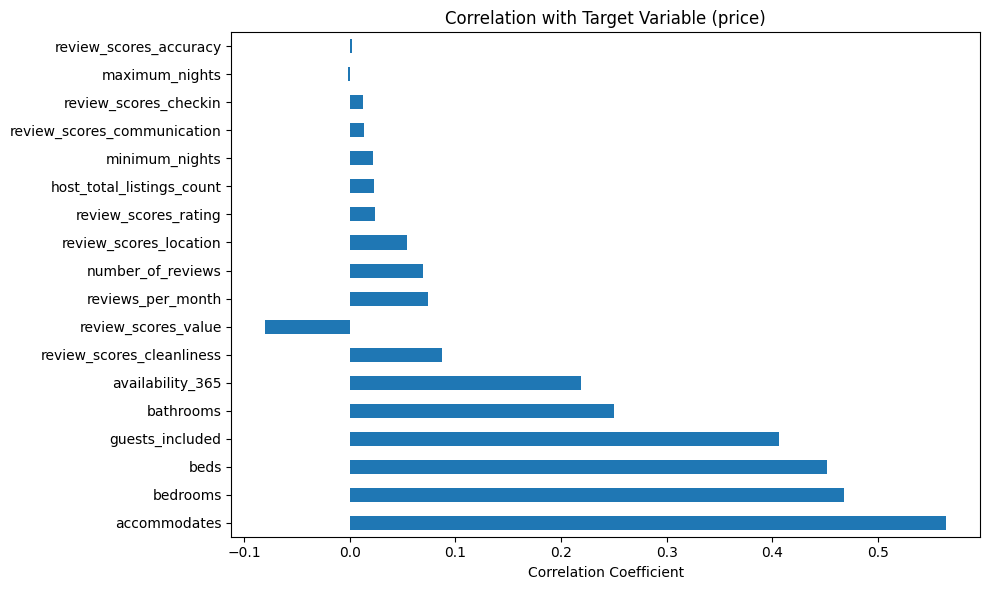

In [88]:
# Let's take a first look at the most correlated variables with price

# Select only numerical columns
numerical_wdf = wdf.select_dtypes(include=['number'])

# Calculate correlations with target variable 'y'
correlations = numerical_wdf.corr()['price'].drop('price').sort_values(key=abs, ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='barh')
plt.title('Correlation with Target Variable (price)')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Expected results such as # of people, bedrooms, beds, etc. being strongly positively correlated. Quite surprising that review_scores_value has negative correlation, but maybe I misunderstand what that column signifies.

--------------------

### 2. (Pre-)processing the data

Our prior exploration step already contained quite a bit of data cleaning, outlier detection and feature selection. In this section, I am not going to spend a lot more time on data cleaning as this is mock data. During the assessment itself I am happy to dive into more sophisticated approaches or provide more detail. 

What I will do in this section:  
1. Some final data cleaning  
2. One-hot encode all categorical variables. 
3. Transform one of the columns containing unstructured data to a usable format through sentiment scoring, embedding or some other technique
4. Drop all rows that contain NaN's in any of the selected columns. More sophisticated approaches could consist of data imputation by filling missing data with the mean/median of the dataset, which brings its own trade-offs. 
5. Select the features I will use for my model

In [89]:
# Some final data cleaning and one-hot encoding
# Make the binary columns adhere to True/False and group the categorical columns by creating an 'Other' rather than having many options

# Apply complete transformation - see utils for the functions
from utils import transform_data_complete

wdf = transform_data_complete(wdf.copy())

# Drop all but summary
wdf = wdf.drop(columns=['space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules'], axis=1)

# Drop all rows with any NaN in any of the columns
wdf = wdf.dropna().reset_index(drop=True)

print(wdf.shape)

Binary variables converted
Created binary features for: ['Internet', 'Wifi', 'Kitchen', 'Heating', 'Washer', 'Cable TV']
Categorical variables encoded
(17276, 83)


Now on to transforming one of the unstructured text data columns, namely the summary column. I will use a language model created by OpenAI to create vector-embeddings of the unstructured text, then reduce the dimensions. In theory this could extract more precise information on the specific listing than the pre-defined categorical variables could, in practice this is mainly a proof of concept. 

In [ ]:
# Embedding one of the unstructured text data columns
# Using batch embedding for speed

def add_embeddings(env_and_api_added=True):
    if env_and_api_added:
        # Run this to test embeddings - expected API costs: 0.02 EUR

        # Imports
        import os
        from dotenv import load_dotenv

        # Load environment variables from .env file
        load_dotenv()

        # Get the API key - fill in your own
        openai_api_key = os.getenv('openai_key')

        from utils import create_batch_embeddings, create_openai_embeddings, reduce_embedding_dimensions

        # Much faster batch processing
        embeddings = create_batch_embeddings(wdf, ['summary'], openai_api_key, 
                                        batch_size=50, dimensions=128)

        reduced_embeddings = reduce_embedding_dimensions(embeddings)

        # Save and add to working data
        reduced_embeddings.to_csv('reduced_embeddings', index=True)
        wdf = wdf.drop(columns=['summary'])
        wdf = pd.concat([wdf, reduced_embeddings], axis=1)

    else:
        # Run this to save compute
        file_path = "reduced_embeddings" 
        reduced_embeddings = pd.read_csv(file_path)

        # Save and add to working data
        wdf = wdf.drop(columns=['summary'])
        wdf = pd.concat([wdf, reduced_embeddings], axis=1)

    return wdf

env_and_api_added = True
wdf = add_embeddings(env_and_api_added)

Processing summary in batches...
  Batch 1/346
  Batch 2/346
  Batch 3/346
  Batch 4/346
  Batch 5/346
  Batch 6/346
  Batch 7/346
  Batch 8/346
  Batch 9/346
  Batch 10/346
  Batch 11/346
  Batch 12/346
  Batch 13/346
  Batch 14/346
  Batch 15/346
  Batch 16/346
  Batch 17/346
  Batch 18/346
  Batch 19/346
  Batch 20/346
  Batch 21/346
  Batch 22/346
  Batch 23/346
  Batch 24/346
  Batch 25/346
  Batch 26/346
  Batch 27/346
  Batch 28/346
  Batch 29/346
  Batch 30/346
  Batch 31/346
  Batch 32/346
  Batch 33/346
  Batch 34/346
  Batch 35/346
  Batch 36/346
  Batch 37/346
  Batch 38/346
  Batch 39/346
  Batch 40/346
  Batch 41/346
  Batch 42/346
  Batch 43/346
  Batch 44/346
  Batch 45/346
  Batch 46/346
  Batch 47/346
  Batch 48/346
  Batch 49/346
  Batch 50/346
  Batch 51/346
  Batch 52/346
  Batch 53/346
  Batch 54/346
  Batch 55/346
  Batch 56/346
  Batch 57/346
  Batch 58/346
  Batch 59/346
  Batch 60/346
  Batch 61/346
  Batch 62/346
  Batch 63/346
  Batch 64/346
  Batch 65/346
 

In [98]:
# Example of testing
# Let's add a small test that checks whether our final working dataframe used for inference is fully numeric/binary
# If it finds a column that does not adhere, change the dtype if possible

def check_and_change_dtype(wdf):
    from pandas.api.types import is_numeric_dtype

    # Note that this is schematic and not very robust - columns of string types would still cause an error
    for col in wdf.columns:
        if not is_numeric_dtype(wdf[col]):
            print(f"{col} not numeric or binary")
            try:
                # First try to convert to int
                wdf = wdf.astype({col:int})
                print(f"{col} converted to int")
            except:
                # If not possible, the columns dtype must be string and we drop it
                wdf = wdf.drop(columns=[col], axis=1)
                print(f"{col} dropped")

    return wdf

wdf = check_and_change_dtype(wdf)

In [57]:
# Final step in this section is feature selection

# Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def rf_feature_selection(X, y, n_features=10): # rule of thumb is square root of number of features
   
   # Split data
    # Make sure to do this prior to the feature selection to prevent data leakage i.e. using test data to select the optimal features
    # A more sophisticated approach would be k-means cross-validation (train/validate/test split)

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
   
   # Feature selection RF
   rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
   rf_selector.fit(X_train, y_train)
   
   # Get top features
   feature_importance = pd.DataFrame({
       'feature': X.columns,
       'importance': rf_selector.feature_importances_
   }).sort_values('importance', ascending=False)
   
   selected_features = feature_importance.head(n_features)['feature'].tolist()
   
   print(f"Selected {len(selected_features)} features")
   
   return selected_features, X_train, X_test, y_train, y_test

wdf_features = wdf.drop(columns=['price', 'extra_people'], axis=1) # Fix the extra_people thing later
features, X_train, X_test, y_train, y_test = rf_feature_selection(wdf_features, wdf['price'])

# Final 10 selected features
features

Selected 10 features


['accommodates',
 'bedrooms',
 'room_type_bucketed_Entire home/apt',
 'bathrooms',
 'availability_365',
 'text_pca_2',
 'guests_included',
 'text_pca_3',
 'text_pca_0',
 'text_pca_1']

Looking at the selected features, a few things catch my attention.   
- Firstly, it makes a lot of sense that bedrooms, accomodates, bathrooms and room type Entire home/apt are strong predictors of price. The larger the listing, the higher the price. However, it could be wise to re-run the analysis with only one of these columns as they are likely strongly correlated.
- Secondly, at first glance it confused me that reviews seem to not factor in to the price as it seems logical that more high-end places get better reviews and are more expensive. However, on second thought, humans strongly anchor their review of a listing against the price they paid, meaning an objectively worse place in all facets can still obtain a higher review than a more high-end place if the perceived price-quality is better. As such, it actually makes perfect sense that reviews do not strongly predict prices.   
- Thirdly, it is surprising to me that the neighbourhood does not seem to predict price strongly. In a real project, I would dive into this deeper as this seems quite odd. One idea to investigate would be to calculate mean/median prices by neighbourhood and see if they differ strongly or not.   
- Lastly, it catches my attention that the reduced embeddings seem to actually strongly predict prices. In theory, it makes sense as the embeddings often contain information on the location, size, amenities and other highlights about the listing, however I am surprised to see that the most light-weight and heavily reduced OpenAI model actually shows such performance.

---------------------


### 3. Design, fit and evaluate the model

It is time to choose a model architecture, train it and then evaluate it. As mentioned in my plan of action, the four dimensions I want to use to choose the optimal model are: the type of y-variable, the underlying data-generating process, scalability and lastly explainability.

Let's go one-by-one:
1. As the y-variable is a continuous, numerical variable (bounded at 0 and 500), classification models are not useful. Remaining are linear models (OLS, Ridge, Lasso, etc.), Tree-based methods (RF, boosted models), neural networks and more unorthodox methods such as k-nearest neighbor regression. 
2. The underlying data-generating process is most likely quite non-linear, meaning we want a model that can deal with non-linear relationships.
3. Under scalability, I would put amount of data needed, computational intensity during training and speed of testing/development. Neural networks can reach very high performance in (almost) any domain, but are also known to need the most data and be quite computationally intensive. Additionally, the degrees of freedom one has when designing a neural network architecture (hidden layers, activation functions, etc.) can slow down development. 
4. The main drawback of neural networks is actually the lack of explainability of how it reaches its prediction. In a production-setting, where the end-user requires not only a point-prediction but also some reasoning as to why, this can be a blocker for trust and therefore adoption, which in turn could invalidate the entire solution. As such, non-black boxes are often preferred, especially in situations where raw accuracy is less important than explainability. How and by whom this solution would be used is thus extremely relevant for model choice.

Conclusion: I will use a tree-based method, as it combines non-linearity with scalability and explainability. In the industry, XGBoost or LightGBM are most commonly used, but I will use a Random Forest model due to hardware limitations.  

In [58]:
# Train model
def rf_final_model(X_train, X_test, y_train, y_test, selected_features):
   # Train final model with selected features
   X_train_sel = X_train[selected_features]
   X_test_sel = X_test[selected_features]
   
   rf_final = RandomForestRegressor(
       n_estimators=100, 
       max_depth=10, 
       random_state=42, 
       n_jobs=-1
   )
   rf_final.fit(X_train_sel, y_train)
   
   # Results
   train_r2 = rf_final.score(X_train_sel, y_train)
   test_r2 = rf_final.score(X_test_sel, y_test)
   
   print(f"Train R²: {train_r2:.4f}")
   print(f"Test R²: {test_r2:.4f}")
   
   return rf_final, X_train_sel, X_test_sel

model, X_train_sel, X_test_sel = rf_final_model(X_train, X_test, y_train, y_test, features)

Train R²: 0.7700
Test R²: 0.4989


Our R-squared is not very high, meaning the model does not explain a lot of the variability in the dependent variable using the 10 selected features. Also, there is a clear difference between train and test, which implies a lack of generalisability.

**Evaluation metrics**  
For a more detailed model evaluation, I will be using two metrics, namely Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE). I picked RMSE as this is the most common choice for models that predict continuous variables for multiple reasons, such as interpretability. A different choice could be, for example, Mean Absolute Errors, which weights large errors less heavily. for my second choice, I picked Mean Absolute Percentage Error, which shows the error as a proportion of the value, because it is even more interpretable due to the scale independence. 

**Robustness**  
Although, we've already discussed various methods to promote robustness, such as cross-validation rather than simple train/test split and outlier removal. To get a good grasp of the robustness of this model, one could apply techniques such as sensitivity analysis or perturbation testing. Both techniques are based on adding small noise to respectively prediction parameters and data to see whether the prediction outcome strongly changes. If so, this points to the model being not robust.

In [59]:
# Evaluate the model

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

def get_rmse_and_mape(model, X_train, X_test, y_train, y_test):
   # Predictions
   y_train_pred = model.predict(X_train)
   y_test_pred = model.predict(X_test)
   
   # RMSE
   train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
   test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
   
   print(f"Train RMSE: {train_rmse:.2f}")
   print(f"Test RMSE: {test_rmse:.2f}")

   # MAPE
   train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
   test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
   
   print(f"Train MAPE: {train_mape:.2f}")
   print(f"Test MAPE: {test_mape:.2f}")
   
   return train_mape, test_mape, train_rmse, test_rmse, y_test, y_test_pred, y_train, y_train_pred

# Usage
train_mape, test_mape, train_rmse, test_rmse, y_test, y_test_pred, y_train, y_train_pred = get_rmse_and_mape(model, X_train_sel, X_test_sel, y_train, y_test)

Train RMSE: 20.76
Test RMSE: 29.91
Train MAPE: 0.30
Test MAPE: 0.34


The RMSE and MAPE are quite high, implying mediocre performance for this model. I am assuming the input variables are not optimal. Additionally, we can see that the train RMSE is quite a bit smaller than the test, meaning the model's generalisability is low due to overfitting. Let's drill down.

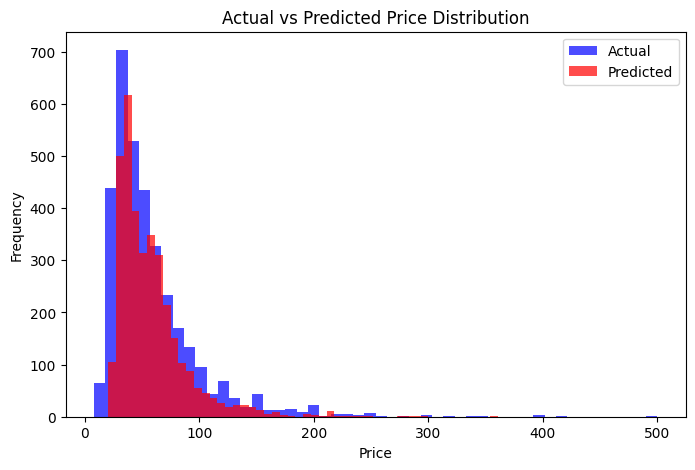

In [60]:
plt.figure(figsize=(8, 5))
plt.hist(y_test, bins=50, alpha=0.7, label='Actual', color='blue')
plt.hist(y_test_pred, bins=50, alpha=0.7, label='Predicted', color='red')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Price Distribution')
plt.legend()
plt.show()

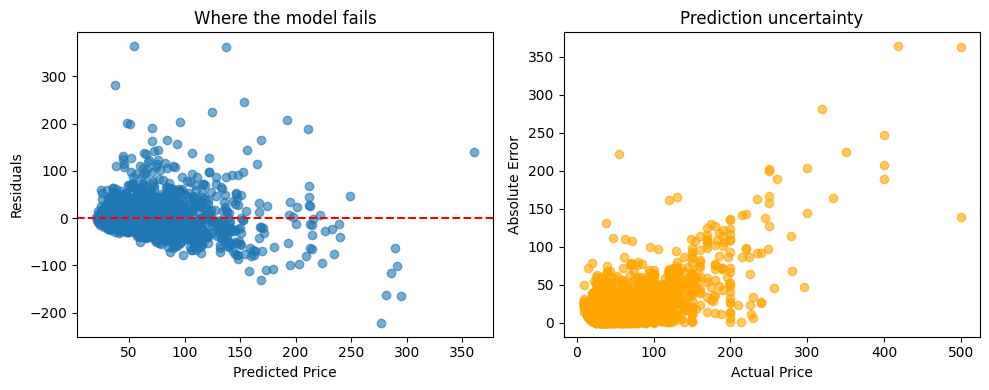

In [61]:
y_pred = model.predict(X_test_sel)
residuals = y_test - y_pred

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Where the model fails')

plt.subplot(1, 2, 2)
plt.scatter(y_test, np.abs(residuals), alpha=0.6, color='orange')
plt.xlabel('Actual Price')
plt.ylabel('Absolute Error')
plt.title('Prediction uncertainty')

plt.tight_layout()
plt.show()

The actuals-predicted and residuals plots show no clear trend in where the model breaks down, except for the fact it struggles to predict higher prices, which makes sense as there is far less data in the tail. The main reason for the poor performance is that the model struggles in the main cloud of medium price listings. Could be due to remaining outliers, sub-optimal feature selection and/or psychological effects of price boundaries on AirBnB.

---------------

### 4. Creating an E2E solution

In order to go from model to E2E solution, the key information is who are the end-users of the solution and what problem does it solve for this group. All system design choices, such as user interface, ETL pipelines, model re-training frequency, evaluation metrics and more, are dependent on these two crucial questions. A few key questions we would need to ask before making any decision on system design are:  
- Who are the end-users? What information do they need? 
- Is the tool meant as a fully automated price predictor and server? Or is it meant as a human-in-the-loop point of information?
    - This is relevant as the need for guardrails and sanity checks heavily increases in a fully automated system.
    - It also influences the need for explainability and the level of 'black box'-ness that can be tolerated
- Is the solution meant as a B2C application or a background process on AirBnB with thousands of concurrent users?
- Will the data always be collected through scraping?
- Will the geographical area remain at Berlin? Or is the tool meant to be applicable across Europe/the World?
- What is the tolerated yearly/monthly downtime? Is there a need for multiple concurrent servers in case of a system error?


There are many more questions we should ask before making any decision on tools, but I will discuss some common choices.

**Hosting the back-end & storage:** Common choices are cloud platforms such as AWS and Azure. Dependent on budget and required throughput, smaller cloud providers such as Render, Vercel or Fly.io would work as well. These platforms often have useful integrations for data storage (Amazon S3) and running ML models (Sagemaker/Bedrock).  
**LLM integration:** The most common choices are to use any of the API's of OpenAI, Anthropic, Mistral, etc. Some thought needs to be given to EU data laws, data privacy and GDPR, costs of API vs. local.  
**User interface:** Dependent on the requirements, the user interface may vary, however for common web applications one could use standard frameworks, such as Next.js on top of React. Simpler ML dashboards are often built in Dash, whilst more expansive solutions have their own custom framework.  
**CI/CD:** The use of Github or Gitlab is essentially required for version control and robust separation of dev and prod environments. Once a new feature or fix has been tested, it can be merged to prod after which tools such as Github Actions (but there are many other options, also dependent on choice of hosting platform) can run automatic deployment based on new commits. Processes such as these ensure a safe and smooth CI/CD pipeline.

More detail on these and other topics such as model deployment or scalable data pipelines, I would love to discuss in person.  

My next steps would be focused partially on feature selection (removing highly correlated variables, sanity checking the embedding variables) and partially on E2E solution design (collecting information on end-user, designing MVP of solution including key features and minimal user interface).

